In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.utils import to_categorical


Mounted at /content/drive


In [2]:
def create_embedding_df(base_dir, label):
    data = []
    for file_name in os.listdir(base_dir):
        file_path = os.path.join(base_dir, file_name)
        if os.path.isfile(file_path) and not re.search("^OUTPUT_ANDROPY_", file_name):
            try:
                with open(file_path, "r") as file:
                    file_content = file.read()
                    data.append({'fileContent': file_content, 'label': label})
            except Exception as e:
                print(f"Error reading file {file_name}: {e}")
    return pd.DataFrame(data)


In [3]:
base_dir_train = "/content/drive/MyDrive/Android_Malware_Features-main"
dirs = {
    "Benign": (os.path.join(base_dir_train, "Benign", "Features_files"), 0),
    "Adware": (os.path.join(base_dir_train, "Malware", "Adware", "Features_files"), 1),
    "Banking": (os.path.join(base_dir_train, "Malware", "Banking", "Features_files"), 2),
    "Riskware": (os.path.join(base_dir_train, "Malware", "Riskware", "Features_files"), 3)
}

dfs = [create_embedding_df(path, label) for path, label in dirs.values()]
df_train = pd.concat(dfs, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df_train['fileContent'])
sequences = tokenizer.texts_to_sequences(df_train['fileContent'])
data = pad_sequences(sequences, maxlen=100)
labels = to_categorical(df_train['label'])


In [4]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1387332 (5.29 MB)
Trainable params: 1387332 (5.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


Epoch 1/10
50/50 [==============================] - 35s 506ms/step - loss: 0.9623 - accuracy: 0.5611 - val_loss: 0.6550 - val_accuracy: 0.6979
Epoch 2/10
50/50 [==============================] - 27s 529ms/step - loss: 0.3755 - accuracy: 0.8660 - val_loss: 0.3167 - val_accuracy: 0.8962
Epoch 3/10
50/50 [==============================] - 25s 495ms/step - loss: 0.1765 - accuracy: 0.9432 - val_loss: 0.1559 - val_accuracy: 0.9518
Epoch 4/10
50/50 [==============================] - 22s 445ms/step - loss: 0.1385 - accuracy: 0.9570 - val_loss: 0.1578 - val_accuracy: 0.9443
Epoch 5/10
50/50 [==============================] - 26s 519ms/step - loss: 0.1260 - accuracy: 0.9615 - val_loss: 0.1615 - val_accuracy: 0.9606
Epoch 6/10
50/50 [==============================] - 23s 465ms/step - loss: 0.1138 - accuracy: 0.9664 - val_loss: 0.1220 - val_accuracy: 0.9612
Epoch 7/10
50/50 [==============================] - 26s 514ms/step - loss: 0.0906 - accuracy: 0.9731 - val_loss: 0.1140 - val_accuracy: 0.9669

In [6]:
model.save("/content/drive/MyDrive/BiLSTM_model.h5")
print("Model saved successfully")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully


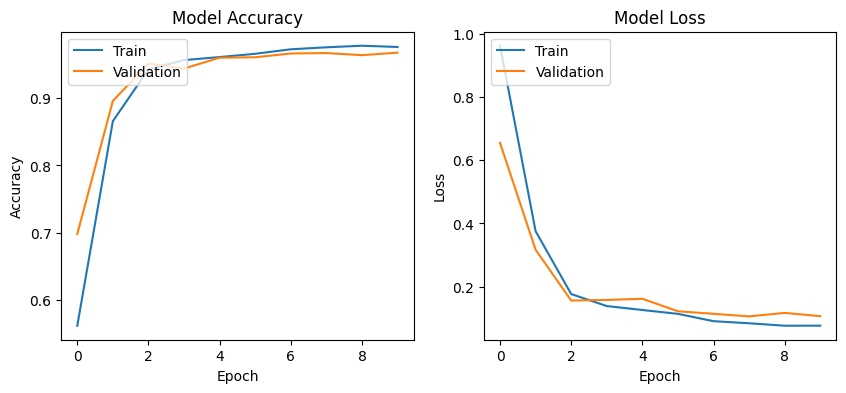

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict classes on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print performance metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Optional: Print the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)


63/63 [==============================] - 4s 35ms/step
Test Accuracy: 0.9785
Test Precision: 0.9784
Test Recall: 0.9785
Test F1 Score: 0.9784
Confusion Matrix:
 [[853   0   0   0]
 [  0 259  15   1]
 [  7  10 374   5]
 [  0   0   5 470]]


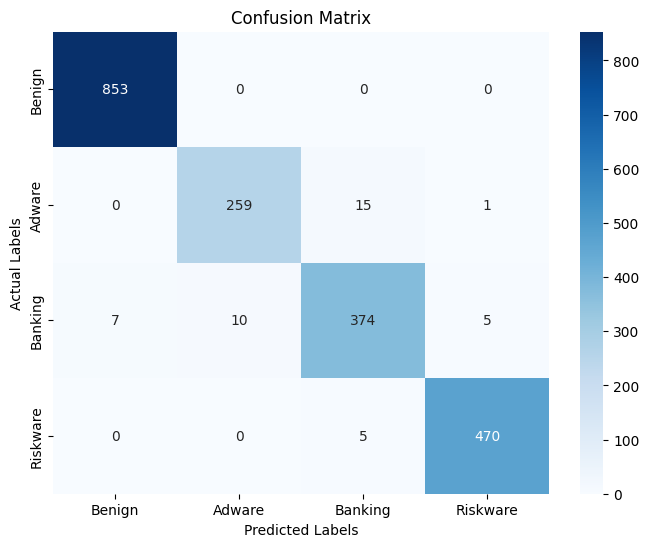

In [9]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=dirs.keys(), yticklabels=dirs.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()
